## Install & Import Libraries

In [1]:
!pip install -U gensim pyLDAvis ipywidgets tables scikit-learn tomotopy numpy scipy

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: gensim in /home/users/sljack/.local/lib/python3.7/site-packages (3.8.3)
Requirement already up-to-date: pyLDAvis in /home/users/sljack/.local/lib/python3.7/site-packages (2.1.2)
Requirement already up-to-date: ipywidgets in /home/users/sljack/.local/lib/python3.7/site-packages (7.5.1)
Requirement already up-to-date: tables in /home/users/sljack/.local/lib/python3.7/site-packages (3.6.1)
Requirement already up-to-date: scikit-learn in /home/users/sljack/.local/lib/python3.7/site-packages (0.23.1)
Requirement already up-to-date: tomotopy in /home/users/sljack/.local/lib/python3.7/site-packages (0.8.1)
Requirement already up-to-date: numpy in /home/users/sljack/.local/lib/python3.7/site-packages (1.19.0)
Requirement already up-to-date: scipy in /home/users/sljack/.local/lib/python3.7/site-packages (1.5.0)


In [2]:
import re
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import json
import re
import matplotlib.pyplot as plt
from tqdm import tqdm

import ipywidgets
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from sklearn.feature_extraction.text import CountVectorizer

import pyLDAvis
# import pyLDAvis.sklearn
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

## Load Extracted Meta Data

Load a list of meta data extracted from the parsed NetCDF files. Each file is just represented as a big string without any additional structure.

In [3]:
doc_df = pd.read_hdf('data/processed/cmip5/cmip5_meta_data.h5')
doc_df.head(3)

/home/users/sljack/.local/lib/python3.7/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return pickle.loads(array.tostring())


,institution,institute_id,experiment_id,source,model_id,forcing,parent_experiment_id,parent_experiment_rip,branch_time,contact,...,proc_log_url,proc_batch,input_files,input_tids,input_creation_date,mo_runid,gfdl_experiment_name,2011-04-22T07:32:05Z,MOHC,2011-04-22T07:32:35Z
0,"Beijing Climate Center (BCC), China Meteorolog...",BCC,decadal1981,bcc-csm1-1:atmosphere: BCC_AGCM2.1 (T42L26); ...,bcc-csm1-1,Nat Ant GHG SD Oz Sl Vl SS Ds BC OC,historical,r1i1p1,1981.0,Dr. Tongwen Wu (twwu@cma.gov.cn),...,,,,,,,,,,
1,CNRM (Centre National de Recherche Meteorologi...,CNRM-CERFACS,decadal1995,CNRM-CM5 2010 Atmosphere: ARPEGE-Climat (V5.2....,CNRM-CM5,"GHG, SA, Sl, Vl, BC, OC, Ds, SS",N/A,N/A,0.0,for all but decadal predictions : contact.CMIP...,...,,,,,,,,,,
2,CNRM (Centre National de Recherches Meteorolog...,CNRM-CERFACS,historicalGHG,CNRM-CM5 2010 Atmosphere: ARPEGE-Climat (V5.2....,CNRM-CM5,GHG,piControl,r1i1p1,146097.0,for all but decadal predictions : contact.CMIP...,...,,,,,,,,,,


In [4]:
cru_doc_df = pd.read_hdf('data/processed/cru/cru_meta_data.h5')
cru_doc_df.head(3)

/home/users/sljack/.local/lib/python3.7/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return pickle.loads(array.tostring())


,CDI,Conventions,history,CDO,file_name,file_path,title,institution,source,references,comment,contact,acknowledgement,version_control,reference,version
0,Climate Data Interface version 1.5.9 (http://c...,CF-1.4,Fri May 31 06:53:55 2013: cdo -f nc import_bin...,Climate Data Operators version 1.5.9 (http://c...,pdsi.penman.vegetat.snow.1911-1920,/badc/cru/data/PDSI/PDSI_CRU_TS_3.10.01_based/...,,,,,,,,,,
1,,CF-1.4,Wed 10 Jul 2013 18:15:41 BST : User ianharris ...,,cru_ts3.21.1991.2000.dtr.st0.nc,/badc/cru/data/cru_ts/cru_ts_3.21/station/dtr/...,in-cell station count for CRU TS3.21 Diurnal T...,"Data held at British Atmospheric Data Centre, ...",Run ID = 1307101324\nData generated by BADC from:,Information on the data is available at http:/...,Data restrictions: for academic research use o...,BADC <badc@rl.ac.uk>,,,,
2,,CF-1.4,Fri 20 Jan 2017 23:41:19 GMT : User ianharris ...,,cru_ts3.24.01.1991.2000.tmpdtr.stn.nc,/badc/cru/data/cru_ts/cru_ts_3.24.01/station/t...,within-CDD station count for CRU TS3.24.01 Mea...,"Data held at British Atmospheric Data Centre, ...",Run ID = 1701201703\nData generated by BADC from:,Information on the data is available at http:/...,Access to these data is available to any regis...,BADC <badc@rl.ac.uk>,This update was supported by NERC NCAS and by ...,,,


## Parsing Meta-data Fields

Here we're going to parse the "interesting" meta-data fields to produce useful information that we can feed into our topic model. We're going to do this for both the CMIP5 and CRU records.

**TODO:** Might want to consider stemming the tokens (e.g. mapping `degrees` -> `degree`)

In [5]:
def join_columns(row):
    """Helper function to combine lists of tokens across dataframe columns"""
    tokens = []
    for c in row.index:
        tokens.extend(row[c])
    return tokens

# Tokenize parts of CMIP5 meta-data
# ---------------------------------

vectorizer = CountVectorizer(token_pattern=r'[a-zA-Z]{3,}', ngram_range=(1, 2), 
                             stop_words='english', lowercase=True)
tokenizer = vectorizer.build_analyzer()

title_vectorizer = CountVectorizer(token_pattern=r'[a-zA-Z]{3,}', ngram_range=(1, 2), 
                             stop_words='english', lowercase=True)
title_tokenizer = title_vectorizer.build_analyzer()

forcing_vectorizer = CountVectorizer(token_pattern=r'[a-zA-Z0-9]{3,}', ngram_range=(1, 2), 
                             stop_words='english', lowercase=True)
forcing_tokenizer = forcing_vectorizer.build_analyzer()

doc_df['source_tokens'] = doc_df.source.map(tokenizer)
doc_df['comment_tokens'] = doc_df.comment.map(tokenizer)
doc_df['forcing_tokens'] = doc_df.forcing.map(forcing_tokenizer )
doc_df['title_tokens'] = doc_df.title.map(title_tokenizer)

# Tag these documents as being part of the CMIP5 data collection
doc_df['collection'] = 'cmip5'

# Expand the forcing terms using a vocabulary derived from the CMIP5 documentation.
cmip_cv_forcing_df = pd.read_csv('data/raw/cmip5_cv_forcing.csv')
cmip_cv_forcing_df.abbreviation = cmip_cv_forcing_df.abbreviation.str.lower()
cmip_cv_forcing_df = cmip_cv_forcing_df.set_index('abbreviation')

def expand_forcings(row):
    forcings_expanded = []
    for t in row:
        if t in cmip_cv_forcing_df.index:
            t = cmip_cv_forcing_df.loc[t][0]
            t = t.strip().lower().split(' ')
            forcings_expanded.extend(t)
        else:
            forcings_expanded.append(t)
    return forcings_expanded

doc_df.forcing_tokens = doc_df.forcing_tokens.map(expand_forcings)

doc_tokens = doc_df[[c for c in doc_df.columns if '_tokens' in c]].apply(join_columns, axis=1)
doc_tokens = doc_tokens.values

# Expand a few more terms to full size.
doc_tokens = map(lambda doc: [re.sub(r'^lon$', 'longitude', x) for x in doc], doc_tokens)
doc_tokens = map(lambda doc: [re.sub(r'^lat$', 'latitude', x) for x in doc], doc_tokens)
doc_tokens = map(lambda doc: [re.sub(r'^climat$', 'climate', x) for x in doc], doc_tokens)
doc_tokens = list(doc_tokens)

# Tokenize parts of CRU meta-data
# ---------------------------------
cru_tokens = cru_doc_df.title.map(tokenizer).values
# Tag these documents as being part of the CRU data collection
cru_doc_df['collection'] = 'cru'

# Combine all documents from both datasets into a single array
# ---------------------------------
doc_tokens = np.concatenate([doc_tokens])

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Combine all documents together into a single dataframe. As not all records have the same fields, fill the empty ones with the empty string rather than NaN values.

In [6]:
all_docs = pd.concat([doc_df], axis=0).fillna('')
all_docs.head()

,institution,institute_id,experiment_id,source,model_id,forcing,parent_experiment_id,parent_experiment_rip,branch_time,contact,...,mo_runid,gfdl_experiment_name,2011-04-22T07:32:05Z,MOHC,2011-04-22T07:32:35Z,source_tokens,comment_tokens,forcing_tokens,title_tokens,collection
0,"Beijing Climate Center (BCC), China Meteorolog...",BCC,decadal1981,bcc-csm1-1:atmosphere: BCC_AGCM2.1 (T42L26); ...,bcc-csm1-1,Nat Ant GHG SD Oz Sl Vl SS Ds BC OC,historical,r1i1p1,1981.0,Dr. Tongwen Wu (twwu@cma.gov.cn),...,,,,,,"[bcc, csm, atmosphere, bcc, agcm, land, bcc, a...","[experiment, starts, historical, run, nov, oce...","[natural, forcing, anthropogenic, forcing, wel...","[bcc, csm, model, output, prepared, cmip, year...",cmip5
1,CNRM (Centre National de Recherche Meteorologi...,CNRM-CERFACS,decadal1995,CNRM-CM5 2010 Atmosphere: ARPEGE-Climat (V5.2....,CNRM-CM5,"GHG, SA, Sl, Vl, BC, OC, Ds, SS",N/A,N/A,0.0,for all but decadal predictions : contact.CMIP...,...,,,,,,"[cnrm, atmosphere, arpege, climat, ocean, nemo...","[soil, layers, depth, scheme, specific, mrlsl,...","[well, mixed, greenhouse, gases]","[cnrm, model, output, prepared, cmip, year, ru...",cmip5
2,CNRM (Centre National de Recherches Meteorolog...,CNRM-CERFACS,historicalGHG,CNRM-CM5 2010 Atmosphere: ARPEGE-Climat (V5.2....,CNRM-CM5,GHG,piControl,r1i1p1,146097.0,for all but decadal predictions : contact.CMIP...,...,,,,,,"[cnrm, atmosphere, arpege, climat, ocean, cnrm...","[soil, layers, depth, scheme, specific, mrlsl,...","[well, mixed, greenhouse, gases]","[cnrm, model, output, prepared, cmip, ghg, cnr...",cmip5
3,CMCC - Centro Euro-Mediterraneo per i Cambiamenti,CMCC,decadal1980,CMCC-CM,CMCC-CM,"Nat,Ant,GHG,SA,TO,Sl",N/A,N/A,0.0,Silvio Gualdi (gualdi@bo.ingv.it),...,,,,,,[cmcc],"[ocean, initialized, values, ocean, reanalyses...","[natural, forcing, anthropogenic, forcing, wel...","[cmcc, model, output, prepared, cmip, year, ru...",cmip5
4,CNRM (Centre National de Recherches Meteorolog...,CNRM-CERFACS,decadal1994,CNRM-CM5 2010 Atmosphere: ARPEGE-Climat (V5.2....,CNRM-CM5,"GHG, SA, Sl, Vl, BC, OC, Ds, SS",N/A,N/A,0.0,for all but decadal predictions : contact.CMIP...,...,,,,,,"[cnrm, atmosphere, arpege, climat, ocean, nemo...",[],"[well, mixed, greenhouse, gases]","[cnrm, model, output, prepared, cmip, year, ru...",cmip5


## Creating the Vocabulary

Instead of using the documents themselves to define the vocabulary, we can draw on the right set of control vocabularies which have already been created by various climate & earth science institutions. Here we using information from:

 - CF Conventions - we're including the words from the variable names and the units as terms in the dictionary
 - ES-Doc - we're including the descriptions of the experiments from the ES-Doc for CMIP5

In [7]:
# Parse the Climate & Forecast conventions
# ---------------------------------

# We will use the CF conventions as the basis for a dictionary of terms which are allowed in our documents.
cf_vectorizer = CountVectorizer(token_pattern=r'[a-zA-Z0-9]{3,}', ngram_range=(1, 2), 
                             min_df=0., max_df=.98, stop_words='english', lowercase=True)
cf_tokenizer = cf_vectorizer.build_analyzer()

cf_df = pd.read_hdf('data/vocabs/cf_conventions.h5')
cf_df['id_tokens'] = cf_df['id'].str.replace('_', ' ').map(cf_tokenizer)
cf_df['unit_tokens'] = cf_df.unit.str.strip()

# CF tokens is the list of (possibly duplicate) terms dervied from control vocabularies
cf_tokens = cf_df[[c for c in cf_df.columns if '_tokens' in c]].apply(join_columns, axis=1).values.tolist()
cf_tokens.extend(cmip_cv_forcing_df[' forcing'].str.strip().str.lower().str.split().values)

# Parse the ES-Doc Names & Descriptions
# ---------------------------------

# Also add these to our control vocabulary
es_doc_vectorizer = CountVectorizer(token_pattern=r'[a-zA-Z0-9.]{3,}', ngram_range=(1, 2), 
                             min_df=0., max_df=.98, stop_words='english', lowercase=True)
es_doc_tokenizer = es_doc_vectorizer.build_analyzer()

es_doc = pd.read_json('data/raw/cmip5_es_doc.json')
es_doc['description']= es_doc.results.map(lambda x: x[2])
es_doc['name']= es_doc.results.map(lambda x: x[4])
# es_doc['tokens'] = es_doc.description.map(es_doc_tokenizer)

# cf_tokens.extend(es_doc.tokens.values.tolist())
cf_tokens.append(es_doc.name.values.tolist())

/home/users/sljack/.local/lib/python3.7/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return pickle.loads(array.tostring())


## Building a Word Embedding

Convert document tokens to a word embedding using a Bag-Of-Words (BOW) representation. For this we're going to use the `gensim` topic modelling library. Once we have the word embedding, we convert it back to a pandas dataframe of shape `(n_documents, n_words)`.

In [8]:
id2word = corpora.Dictionary(cf_tokens)
bow = [id2word.doc2bow(text) for text in doc_tokens]

# tf_idf = gensim.models.TfidfModel(bow)  # fit model
# bow = tf_idf[bow]

columns = np.unique([id2word[x] for x in id2word])

doc_embedding = gensim.matutils.corpus2csc(bow, num_terms=len(columns), num_docs=len(doc_tokens)).T
doc_embedding = np.array(doc_embedding.todense())

doc_embedding = pd.DataFrame(doc_embedding, columns=columns)
# doc_embedding.to_hdf('data/embeddings/cmip5_and_cf.h5', key='data')

Plot the distance between each document vector for the whole dataset. There doesn't appear to be a whole lot of correlation between the documents from the CMIP5 dataset and documents from the CRU dataset, but there is some.

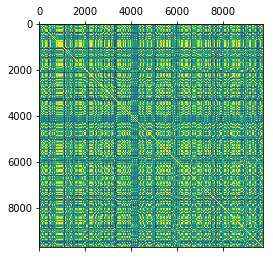

In [9]:
from matplotlib.colors import LogNorm
from sklearn.metrics.pairwise import cosine_similarity

dist = cosine_similarity(doc_embedding, doc_embedding)

plt.matshow(dist)

## Create the Topic Model

Here we're going to use Latent Dirichlet Allocation (LDA) to model topics. This model requires the number of topics to be known in advance as a parameter.

Rebuild the model with the best looking coherence score. In our case it is 4.

In [33]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## Visualise the Topics

We can plot the topics using the very useful `pyLDAvis` tool. This will show a two projection of the document topic clusters.

In [34]:
pyLDAvis.gensim.prepare(lda_model, bow, dictionary=id2word, mds='mmds')

/home/users/sljack/.local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.019728  0.382496       1        1  53.612526
9      0.317406  0.185442       2        1  16.136765
7      0.108729  0.280691       3        1  14.506860
6     -0.181370  0.235353       4        1   9.660941
4     -0.285148  0.055199       5        1   2.746752
8     -0.123168  0.089474       6        1   2.148529
1      0.254703 -0.190848       7        1   1.080346
0     -0.036961 -0.345936       8        1   0.035766
5     -0.036959 -0.345936       9        1   0.035761
3     -0.036960 -0.345936      10        1   0.035750, topic_info=     Category          Freq                  Term         Total  loglift  \
term                                                                       
83    Default  12073.000000                 model  12073.000000  30.0000   
5323  Default   5509.000000               forcing   5509.000000  29.0000   
5     Default   6887.000000                   sea   6887.000000  28.0000   
5529  Default  11401.000000                 gases  11401.000000  27.0000   
3276  Default  11380.000000                 mixed  11380.000000  26.0000   
5530  Default  11382.000000            greenhouse  11382.000000  25.0000   
5531  Default  11375.000000                  well  11375.000000  24.0000   
876   Default   7320.000000                  land   7320.000000  23.0000   
75    Default   2791.000000                 level   2791.000000  22.0000   
885   Default   2764.000000                  soil   2764.000000  21.0000   
3641  Default   2733.000000                scheme   2733.000000  20.0000   
947   Default   2714.000000              specific   2714.000000  19.0000   
1046  Default   2714.000000                 depth   2714.000000  18.0000   
3314  Default   2969.000000               natural   2969.000000  17.0000   
387   Default   2732.000000                 cfc12   2732.000000  16.0000   
377   Default   2732.000000                 cfc11   2732.000000  15.0000   
3260  Default   9027.000000                 ocean   9027.000000  14.0000   
81    Default   9156.000000            atmosphere   9156.000000  13.0000   
4870  Default   1708.000000            industrial   1708.000000  12.0000   
331   Default   2073.000000         anthropogenic   2073.000000  11.0000   
1407  Default   1783.000000              latitude   1783.000000  10.0000   
1042  Default   1783.000000             longitude   1783.000000   9.0000   
29    Default   6513.000000                   ice   6513.000000   8.0000   
31    Default   6491.000000               sea ice   6491.000000   7.0000   
3854  Default   2912.000000         approximation   2912.000000   6.0000   
1405  Default   3300.000000                  grid   3300.000000   5.0000   
94    Default   2435.000000             effective   2435.000000   4.0000   
5419  Default    788.000000             component    788.000000   3.0000   
924   Default   2217.000000                 river   2217.000000   2.0000   
5543  Default    587.000000                  amip    587.000000   1.0000   
...       ...           ...                   ...           ...      ...   
1903  Topic10      0.010866                 142ce      0.679623   3.8005   
1867  Topic10      0.010866                 136cs      0.679623   3.8005   
1859  Topic10      0.010866            135mcs air      0.679623   3.8005   
1860  Topic10      0.010866  concentration 135mcs      0.679623   3.8005   
1861  Topic10      0.010866                135mxe      0.679623   3.8005   
1862  Topic10      0.010866            135mxe air      0.679623   3.8005   
1863  Topic10      0.010866  concentration 135mxe      0.679623   3.8005   
1864  Topic10      0.010866                 135xe      0.679623   3.8005   
1865  Topic10      0.010866             135xe air      0.679623   3.8005   
1866  Topic10      0.010866   concentration 135xe      0.679623   3.8005   
1868  Topic10      0.010866             1

## Query the model for a information about a topic

In [32]:
len(lda_model.show_topics())

10

Pick a particular term to look-up in the model. Find the topics for that term.

In [35]:
#cfc113
topics = lda_model.get_term_topics(id2word.token2id['cfc113'])
print(topics)
topic_id = sorted(topics, key=lambda x: x[1])[-1][0]
print(topic_id)

[(4, 0.0606467)]
4


Find all of the documents that match with the topics.

In [36]:
indices = []
for i, x in enumerate(lda_model.get_document_topics(bow)):
    topic_ids = [item[0] for item in x]
    if topic_id in topic_ids:
        indices.append(i)

Plot the top 20 terms for the chosen topic

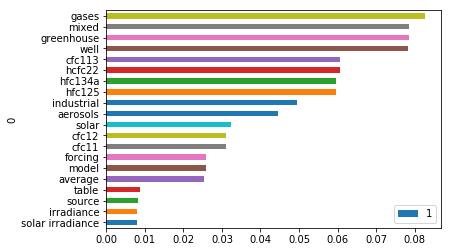

In [40]:
(pd.DataFrame(lda_model.show_topic(topic_id, 20))
    .sort_values(1)
    .plot
    .barh(x=0, y=1))

Which organisations occur most frequently in this topic?

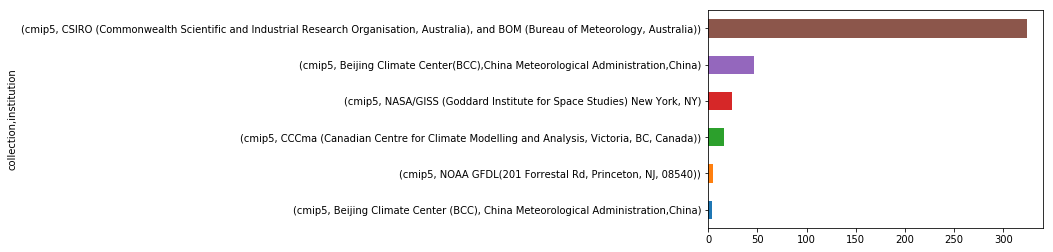

In [38]:
(all_docs.iloc[indices]
     .groupby(['collection', 'institution'])
     .institution
     .count()
     .sort_values()
     .plot(kind='barh'))

Which experiments occur most frequently in this topic?

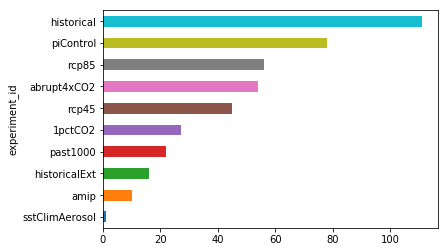

In [39]:
(all_docs.iloc[indices]
     .groupby('experiment_id')
     .institution
     .count()
     .sort_values()
     .iloc[-10:]
     .plot(kind='barh'))